In [1]:
 #load Raw data from TDT ECoG maschine, plz run ""
import numpy as np
import scipy.io as scio
from scipy import signal
import tdt
import os
import matplotlib.pyplot as plt
import json
from scipy.fftpack import fft
from random import shuffle
import h5py
import scipy.io as scio
import math
import mne
import torch   
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import matplotlib
plt.rcParams['axes.unicode_minus'] = False
# matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['font.size'] = 10
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

freq = 400
HS = 69
elec = 74
PATH='/public/DATA/overt_reading/points'
bands_list = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 70),
    'high gamma':(70,150),
    'else2':(150,min(freq/2, 300))
}

# 1. envelop analysis
## 1.2 load cue and read data

In [2]:
# load aligned data and plot average signal
aligned_ecog_data_path = f'/public/DATA/overt_reading/aligned_ecogdata/HS{HS}/{freq}/bands/'
num_blocks = int(len(os.listdir(aligned_ecog_data_path)) / 4)

band_cue_data_all, band_read_data_all = {}, {}
z_band_cue_data_all, z_band_read_data_all = {}, {}
for band in bands_list:
    for b in range(num_blocks):
        data_block_cue = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_cue_data.npy'), allow_pickle=True).item()
        data_block_read = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_read_data.npy'), allow_pickle=True).item()
        z_block_cue = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_z_cue_data.npy'), allow_pickle=True).item()
        z_block_read = np.load(os.path.join(aligned_ecog_data_path, f'{str(b)}_z_read_data.npy'), allow_pickle=True).item()

        band_cue = data_block_cue[band]
        band_read = data_block_read[band]
        z_band_cue = z_block_cue[band]
        z_band_read = z_block_read[band]
        band_cue_data_all.setdefault(band, []).append(band_cue)
        band_read_data_all.setdefault(band, []).append(band_read)
        z_band_cue_data_all.setdefault(band, []).append(z_band_cue)
        z_band_read_data_all.setdefault(band, []).append(z_band_read)
    
    # 每一个band 对应了6个block的数据
    # print(band_cue_data_all[band].shape)
    band_cue_data_all[band] = np.vstack(band_cue_data_all[band])
    _, _, shape1, shape2 = band_cue_data_all[band].shape
    band_cue_data_all[band] = band_cue_data_all[band].reshape(-1, shape1, shape2)
    band_read_data_all[band] = np.vstack(band_read_data_all[band]).reshape(-1, shape1, shape2)
    z_band_cue_data_all[band] = np.vstack(z_band_cue_data_all[band]).reshape(-1, shape1, shape2)
    z_band_read_data_all[band] = np.vstack(z_band_read_data_all[band]).reshape(-1, shape1, shape2)
    print(band_cue_data_all[band].shape) # (360, 256, 380)


(360, 256, 380)
(360, 256, 380)
(360, 256, 380)
(360, 256, 380)
(360, 256, 380)
(360, 256, 380)
(360, 256, 380)


## 1.3 calculate mean envelop and plot

In [34]:
def plot_mean_envelop(bands_list, HS, freq, z_band_cue_data_all, z_band_read_data_all):
    
    n_bands = len(bands_list)
    
    # 创建大图
    fig, axes = plt.subplots(n_bands, 1, figsize=(10, 5 * n_bands))

    for i, band in enumerate(bands_list):
        band_cue_data = z_band_cue_data_all[band]
        band_read_data = z_band_read_data_all[band]

        # 计算平均包络
        cue_mean_envelope = np.mean(band_cue_data, axis=1)
        read_mean_envelope = np.mean(band_read_data, axis=1)

        # 绘制平均包络
        axes[i].plot(cue_mean_envelope, label='Cue Task', color='blue')
        axes[i].plot(read_mean_envelope, label='Read Task', color='orange')
        
        # 设置图形标题和标签
        axes[i].set_title(f'HS{HS} Average Envelope for {band}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude Envelope')
        
        # 设置 x 轴刻度（将时间步转换为秒）
        time_steps = np.linspace(-0.2, 0.75, cue_mean_envelope.shape[1])
        
        # 设置 x 轴刻度
        tick_indices = np.arange(0, len(time_steps), 50)  # 每 50 个时间步
        axes[i].set_xticks(tick_indices)
        axes[i].set_xticklabels(np.round(time_steps[tick_indices], 2))  # 显示对应的秒数
        
        # 添加垂直线
        zero_index = np.argmin(np.abs(time_steps))  # 找到距离0最近的位置
        axes[i].axvline(zero_index, color='gray', linewidth=0.5)
        
        # axes[i].legend(loc='upper right')
        
        # if i == n_bands - 1:
        #     axes[i].legend(loc='upper right')

    # 调整布局
    plt.tight_layout()
    plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

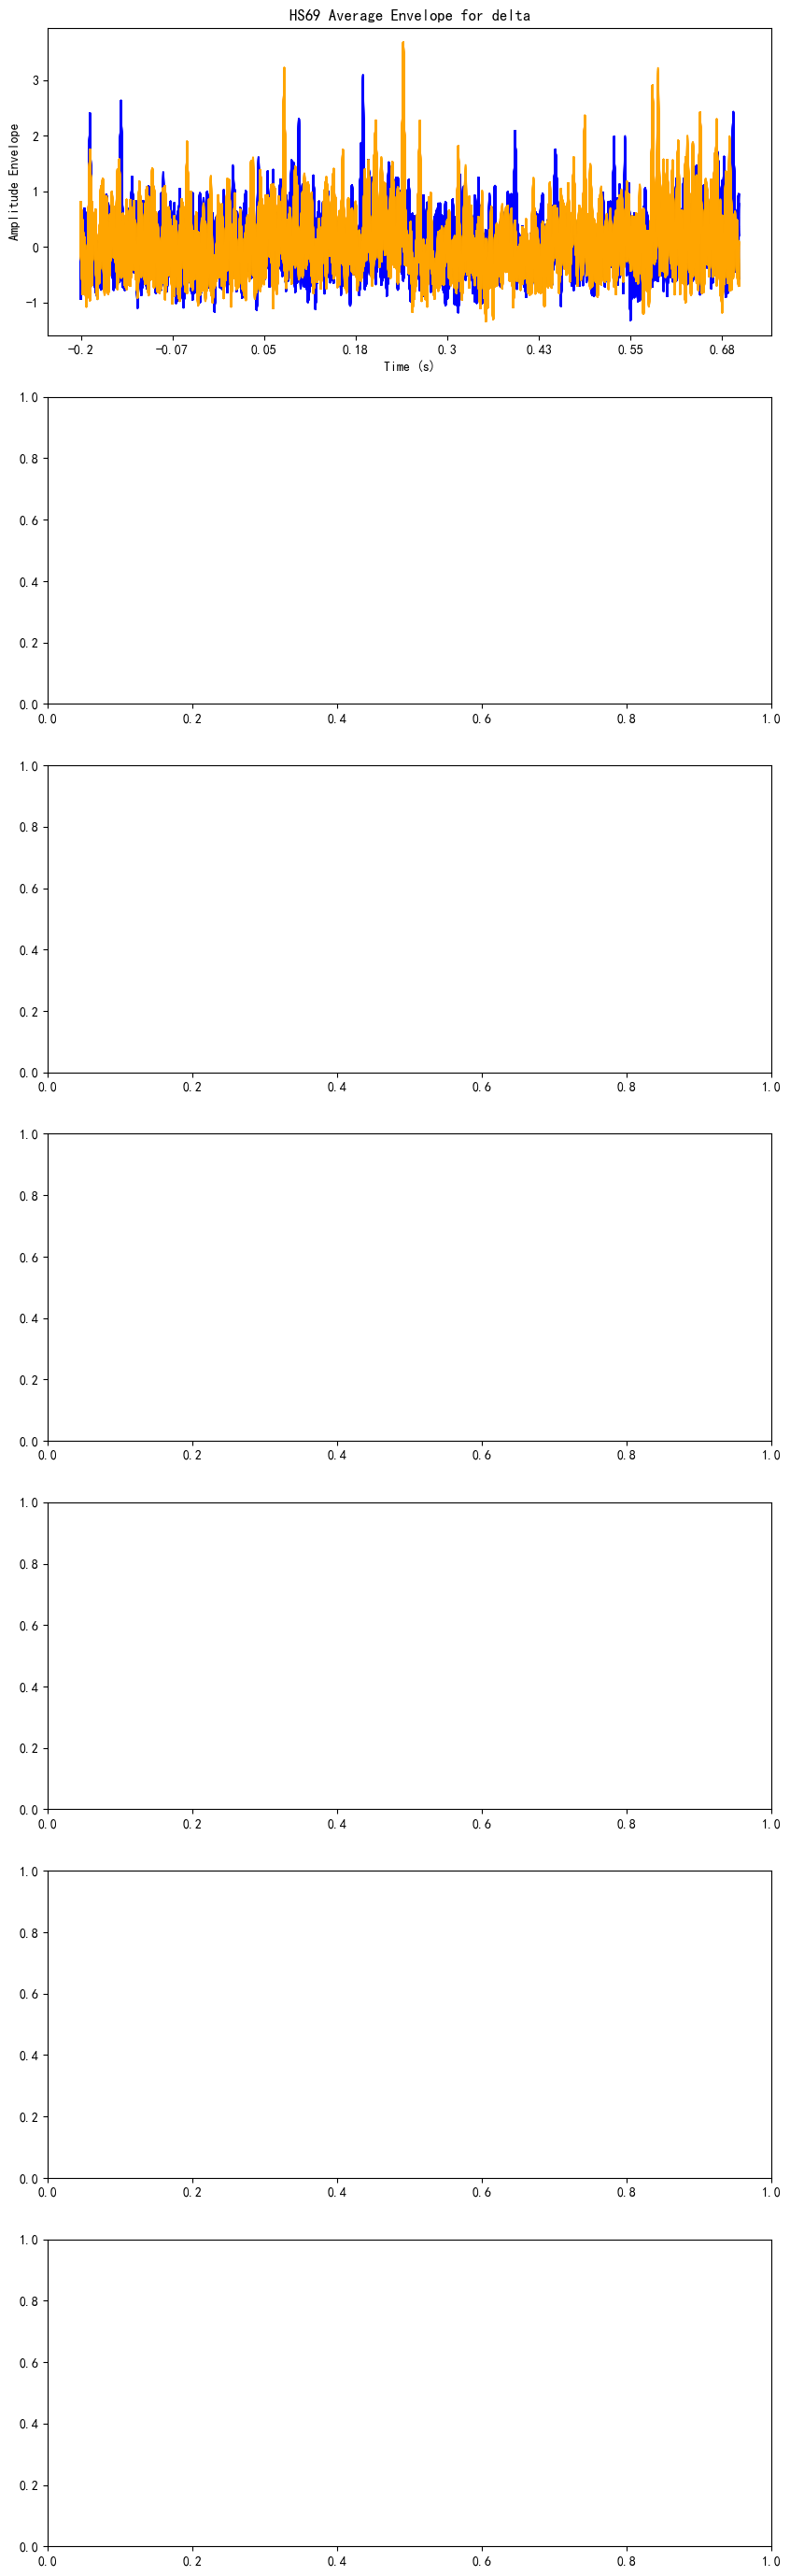

In [33]:
plot_mean_envelop(bands_list, HS, freq, z_band_cue_data_all, z_band_read_data_all)